In [0]:
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
#transform objects
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

In [4]:
train_set = torchvision.datasets.CIFAR10(
    root='./data',
    download=True,
    train=True,
    transform=transform_train
)

test_set = torchvision.datasets.CIFAR10(
    root='./data',
    download=True,
    train=False,
    transform=transform_test
)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
from torch.utils.data import DataLoader

In [0]:
num_classes = 10
batch_size = 4

In [0]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
8


In [0]:
def imgshow(img, title):
  npimg = img.numpy() / 2 +0.5 #unNormalize
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images, labels = iter(dataloader).next()
  img = torchvision.utils.make_grid(images)
  imgshow(img, title=[str(x.item()) for x in labels])

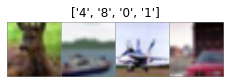

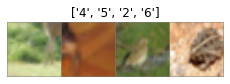

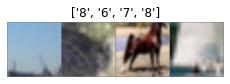

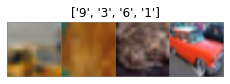

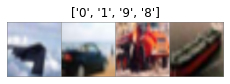

In [0]:
for i in range(5): # see 5 batches
  show_batch_images(train_loader)

##### VGG16

In [0]:
from torchvision import models

In [0]:
vgg = models.vgg16_bn()

In [0]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
vgg.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [0]:
vgg.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [0]:
# one way when defining vgg model give n_classes = 10 but,

final_in_features = vgg.classifier[-1].in_features    #input to last layer
mod_classifier = list(vgg.classifier.children())[:-1] #all classifier llayer except the last
mod_classifier.extend([nn.Linear(final_in_features, num_classes)]) #extending final_in_features=>input, num_classes=>output
mod_classifier

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=10, bias=True)]

In [0]:
#modify classfier to mod_classifier
vgg.classifier = nn.Sequential(*mod_classifier) #without * error --> list is not a Module subclas
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

##### Train CiFAR10


In [0]:
batch_size = 16 #Gpu memory limitations ¯\_(ツ)_/¯

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [0]:
def evaluation(dataloader, model):
  total, correct = 0,0
  for data in dataloader:#per batch
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0 / 3125, Loss: 1.72
Iteration: 100 / 3125, Loss: 1.85
Iteration: 200 / 3125, Loss: 1.92
Iteration: 300 / 3125, Loss: 2.15
Iteration: 400 / 3125, Loss: 1.97
Iteration: 500 / 3125, Loss: 1.83
Iteration: 600 / 3125, Loss: 1.88
Iteration: 700 / 3125, Loss: 1.50
Iteration: 800 / 3125, Loss: 1.73
Iteration: 900 / 3125, Loss: 1.97
Iteration: 1000 / 3125, Loss: 1.63
Iteration: 1100 / 3125, Loss: 1.43
Iteration: 1200 / 3125, Loss: 2.31
Iteration: 1300 / 3125, Loss: 1.62
Iteration: 1400 / 3125, Loss: 1.95
Iteration: 1500 / 3125, Loss: 1.69
Iteration: 1600 / 3125, Loss: 1.66
Iteration: 1700 / 3125, Loss: 1.84
Iteration: 1800 / 3125, Loss: 1.91
Iteration: 1900 / 3125, Loss: 1.86
Iteration: 2000 / 3125, Loss: 2.02
Iteration: 2100 / 3125, Loss: 1.69
Iteration: 2200 / 3125, Loss: 1.69
Iteration: 2300 / 3125, Loss: 2.07
Iteration: 2400 / 3125, Loss: 1.98
Iteration: 2500 / 3125, Loss: 1.70
Iteration: 2600 / 3125, Loss: 1.68
Iteration: 2700 / 3125, Loss: 1.63
Iteration: 2800 / 3125, Loss: 1.

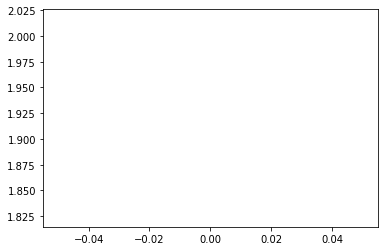

CPU times: user 26min 40s, sys: 19min 19s, total: 45min 59s
Wall time: 46min 1s


In [0]:
%%time
loss_arr = []
loss_epochs_arr = []
max_epochs = 1

n_iter = np.ceil(50000/batch_size)

for epochs in range(max_epochs):

  for i, data in enumerate(train_loader):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i % 100 == 0:
      print('Iteration: %d / %d, Loss: %0.2f' % (i, n_iter, loss.item()))

    loss_arr.append(loss.item()) # loss after every step

  loss_epochs_arr.append(loss.item()) #loss after each epoch

  print('Epoch %d / %d, Test acc: %0.2f, Train acc: %0.2f' % (epochs, max_epochs, evaluation(test_loader, vgg), evaluation(train_loader, vgg)))
  print('-----------------------------------------------------------')
plt.plot(loss_epochs_arr)
plt.show()

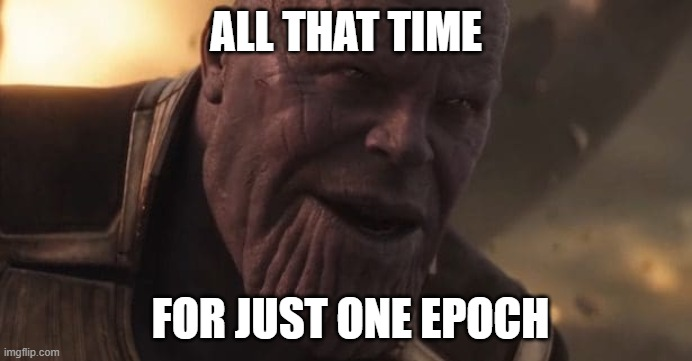

This much time is taken by only one epoch if training from scratch + cifar10 has only 50000 samples only

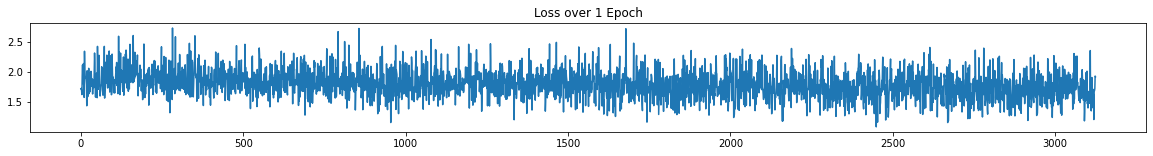

In [0]:
plt.figure(figsize=(20,2))
plt.plot(loss_arr)
plt.title('Loss over 1 Epoch')
plt.show()

---

##### Freezze conv layers

In [0]:
batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [0]:
vgg = models.vgg16_bn(pretrained=True)

In [0]:
for param in vgg.parameters():
  param.requires_grad = False #freezing layers

In [0]:
final_in_features = vgg.classifier[-1].in_features
vgg.classifier[-1] = nn.Linear(final_in_features, out_features=num_classes)

In [0]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [0]:
%%time
loss_arr = []
loss_epochs_arr = []
max_epochs = 1

n_iter = np.ceil(50000/batch_size)

for epochs in range(max_epochs):

  for i, data in enumerate(train_loader):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i % 100 == 0:
      print('Iteration: %d / %d, Loss: %0.2f' % (i, n_iter, loss.item()))

    loss_arr.append(loss.item()) # loss after every step

  loss_epochs_arr.append(loss.item()) #loss after each epoch

  print('Epoch %d / %d, Test acc: %0.2f, Train acc: %0.2f' % (epochs, max_epochs, evaluation(test_loader, vgg), evaluation(train_loader, vgg)))
  print('-----------------------------------------------------------')

Iteration: 0 / 3125, Loss: 2.33
Iteration: 100 / 3125, Loss: 2.36
Iteration: 200 / 3125, Loss: 1.92
Iteration: 300 / 3125, Loss: 1.27
Iteration: 400 / 3125, Loss: 1.56
Iteration: 500 / 3125, Loss: 1.74
Iteration: 600 / 3125, Loss: 1.60
Iteration: 700 / 3125, Loss: 2.37
Iteration: 800 / 3125, Loss: 1.91
Iteration: 900 / 3125, Loss: 2.41
Iteration: 1000 / 3125, Loss: 2.54
Iteration: 1100 / 3125, Loss: 1.15
Iteration: 1200 / 3125, Loss: 1.93
Iteration: 1300 / 3125, Loss: 2.31
Iteration: 1400 / 3125, Loss: 1.61
Iteration: 1500 / 3125, Loss: 2.37
Iteration: 1600 / 3125, Loss: 2.09
Iteration: 1700 / 3125, Loss: 1.32
Iteration: 1800 / 3125, Loss: 2.08
Iteration: 1900 / 3125, Loss: 1.53
Iteration: 2000 / 3125, Loss: 1.86
Iteration: 2100 / 3125, Loss: 1.36
Iteration: 2200 / 3125, Loss: 1.43
Iteration: 2300 / 3125, Loss: 2.46
Iteration: 2400 / 3125, Loss: 2.84
Iteration: 2500 / 3125, Loss: 1.98
Iteration: 2600 / 3125, Loss: 2.56
Iteration: 2700 / 3125, Loss: 1.28
Iteration: 2800 / 3125, Loss: 2.

KeyboardInterrupt: ignored

Min loss was 1.15 as far as we can see, but current loss is 1.94  so we will save checkpoints where the loss was min.

In [0]:
import copy # to make deep copy of DS

In [0]:
%%time
loss_arr = []
loss_epochs_arr = []
max_epochs = 1
min_loss = 1000
loss_thres = 0.5

n_iter = np.ceil(50000/batch_size)

for epochs in range(max_epochs):

  for i, data in enumerate(train_loader):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(vgg.state_dict())
      print('Min. loss: %0.2f'%(min_loss))

      '''
      Additionally
      we can stop training if loss reaches some min. threshold

      if loss.item <= loss_thresh:
        break:
      '''

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i % 100 == 0:
      print('Iteration: %d / %d, Loss: %0.2f' % (i, n_iter, loss.item()))

    loss_arr.append(loss.item()) # loss after every step

  loss_epochs_arr.append(loss.item()) #loss after each epoch

Min. loss: 2.67
Iteration: 0 / 3125, Loss: 2.67
Min. loss: 2.53
Min. loss: 1.25
Min. loss: 1.24
Min. loss: 1.20
Min. loss: 0.71
Iteration: 100 / 3125, Loss: 3.01
Iteration: 200 / 3125, Loss: 2.27
Iteration: 300 / 3125, Loss: 1.44
Iteration: 400 / 3125, Loss: 2.53
Iteration: 500 / 3125, Loss: 3.01
Iteration: 600 / 3125, Loss: 1.95
Iteration: 700 / 3125, Loss: 1.38
Min. loss: 0.52
Iteration: 800 / 3125, Loss: 1.95
Iteration: 900 / 3125, Loss: 1.80
Iteration: 1000 / 3125, Loss: 1.30
Iteration: 1100 / 3125, Loss: 2.69
Iteration: 1200 / 3125, Loss: 1.18
Iteration: 1300 / 3125, Loss: 2.11
Iteration: 1400 / 3125, Loss: 1.53
Iteration: 1500 / 3125, Loss: 3.94
Iteration: 1600 / 3125, Loss: 1.84
Iteration: 1700 / 3125, Loss: 1.70
Iteration: 1800 / 3125, Loss: 2.45
Iteration: 1900 / 3125, Loss: 2.11
Iteration: 2000 / 3125, Loss: 2.02
Iteration: 2100 / 3125, Loss: 1.21
Iteration: 2200 / 3125, Loss: 2.11
Iteration: 2300 / 3125, Loss: 2.78
Iteration: 2400 / 3125, Loss: 2.69
Iteration: 2500 / 3125, L

In [0]:
print('Best model performance:')
vgg.load_state_dict(best_model)
print(evaluation(train_loader, vgg), evaluation(test_loader, vgg))

Best model performance:
43.718 43.56


And if we want more training, we can just load the best model from last time and continue from there.

In [0]:
del(vgg)

#### Resnet

In [12]:
resnet = models.resnet18(pretrained=True)
resnet

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet.parameters():
  param.requires_grad = False 

In [0]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, out_features=num_classes)

In [15]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.05)

In [0]:
import copy

Min. loss: 2.88
Iteration: 0 / 3125, Loss: 2.88
Min. loss: 2.70
Min. loss: 2.15
Min. loss: 2.04
Min. loss: 1.74
Min. loss: 1.39
Min. loss: 1.13
Iteration: 100 / 3125, Loss: 2.23
Min. loss: 1.09
Iteration: 200 / 3125, Loss: 1.77
Min. loss: 0.98
Min. loss: 0.96
Min. loss: 0.92
Iteration: 300 / 3125, Loss: 1.96
Min. loss: 0.91
Min. loss: 0.88
Iteration: 400 / 3125, Loss: 2.41
Min. loss: 0.84
Iteration: 500 / 3125, Loss: 1.03
Min. loss: 0.82
Min. loss: 0.64
Iteration: 600 / 3125, Loss: 2.45
Iteration: 700 / 3125, Loss: 2.54
Iteration: 800 / 3125, Loss: 2.64
Min. loss: 0.59
Iteration: 900 / 3125, Loss: 2.23
Iteration: 1000 / 3125, Loss: 1.15
Min. loss: 0.56
Iteration: 1100 / 3125, Loss: 1.48
Iteration: 1200 / 3125, Loss: 3.52
Iteration: 1300 / 3125, Loss: 1.45
Iteration: 1400 / 3125, Loss: 1.39
Iteration: 1500 / 3125, Loss: 3.12
Iteration: 1600 / 3125, Loss: 1.22
Iteration: 1700 / 3125, Loss: 1.45
Iteration: 1800 / 3125, Loss: 2.22
Min. loss: 0.43
Iteration: 1900 / 3125, Loss: 2.00
Iteratio

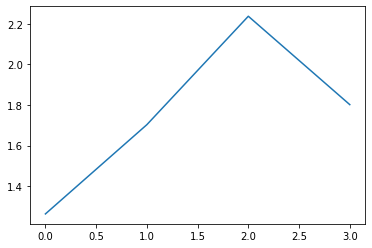

CPU times: user 24min 11s, sys: 7min 27s, total: 31min 39s
Wall time: 31min 40s


In [19]:
%%time
loss_arr = []
loss_epochs_arr = []
max_epochs = 4
min_loss = 1000

n_iter = np.ceil(50000/batch_size)

for epochs in range(max_epochs):

  for i, data in enumerate(train_loader):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = resnet(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(resnet.state_dict())
      print('Min. loss: %0.2f'%(min_loss))

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i % 100 == 0:
      print('Iteration: %d / %d, Loss: %0.2f' % (i, n_iter, loss.item()))

    loss_arr.append(loss.item()) 

  loss_epochs_arr.append(loss.item()) 
  print('Epoch %d / %d, Test acc: %0.2f, Train acc: %0.2f' % (epochs, max_epochs, evaluation(test_loader, resnet), evaluation(train_loader, resnet)))
  print('-----------------------------------------------------------')
plt.plot(loss_epochs_arr)
plt.show()

In [20]:
print("Min. Loss model's performance:")
resnet.load_state_dict(best_model)
print(evaluation(train_loader, resnet), evaluation(test_loader, resnet))

Min. Loss model's performance:
52.708 52.44


Final model acc is better than min. loss model??
</br>Better to chekpoint afte epochs when model has gone through complete dataset.